# Grided into ERA5


In [1]:
from easygems import healpix as egh
import healpy as hp

import xarray as xr
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import sys
sys.path.append('/scratch/nf33/sc5932/hk25-AusNode-TConvZones/functions')
from SC_function import get_nn_lon_lat_index

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [5]:
mean_era5_loaded = xr.open_dataset('/scratch/nf33/sc5932/Data/regridded/mean_era5.nc').tp

lon = mean_era5_loaded['longitude'].values
lat = mean_era5_loaded['latitude'].values
### UM regridded to era5

## annual mean

In [14]:
mean_imerg= xr.open_dataset('/scratch/nf33/sc5932/Data/mean_imerg_mm_h.nc').precipitation
mean_imerg

<xarray.DataArray 'precipitation' (cell: 3145728)> Size: 13MB
[3145728 values with dtype=float32]
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      float64 8B ...

In [ ]:
this_nside = hp.get_nside(mean_imerg)
cells = get_nn_lon_lat_index(this_nside, lon, lat) 
mean_imerg_regrid = mean_imerg.isel(cell = cells)

In [ ]:
mean_imerg_aligned = mean_imerg_regrid.rename({'lat': 'latitude', 'lon': 'longitude'})

# Drop unrelated coords if needed (optional but cleaner)
mean_imerg_aligned = mean_imerg_aligned.drop_vars(['cell', 'crs'], errors='ignore')

mean_imerg_aligned.to_netcdf('/scratch/nf33/sc5932/Data/mean_imerg_aligned.nc')


## season

In [ ]:
import xarray as xr
import glob
import os
season_order = ['DJF', 'MAM', 'JJA', 'SON']
file_list = []
folder = "/scratch/nf33/sc5932/Data/"

# Append matching files in desired order
for season in season_order:
    files = sorted(glob.glob(os.path.join(folder, f"season_imerg_{season}*.nc")))
    file_list.extend(files)



In [6]:
season_imerg_all = []
for i in range(4):
    each_imerg = xr.open_dataset(file_list[i]).precipitation

    this_nside = hp.get_nside(each_imerg )
    cells = get_nn_lon_lat_index(this_nside, lon, lat) 
    season_imerg_regrid = each_imerg .isel(cell = cells)
    season_imerg_aligned = season_imerg_regrid.rename({'lat': 'latitude', 'lon': 'longitude'})

    # Drop unrelated coords if needed (optional but cleaner)
    season_imerg_aligned = season_imerg_aligned.drop_vars(['cell', 'crs','season'], errors='ignore')
    season_imerg_all.append(season_imerg_aligned)

In [15]:
season_imerg_merged = xr.concat(season_imerg_all, dim = 'season')

In [21]:
season_imerg_merged = season_imerg_merged.assign_coords(season=season_order)
season_imerg_merged.to_netcdf('/scratch/nf33/sc5932/Data/regridded/seasonal_imerg_aligned.nc')



Text(0.5, 1.0, 'UM Daily Mean Precipitation from Feb 2020 to March 2021')

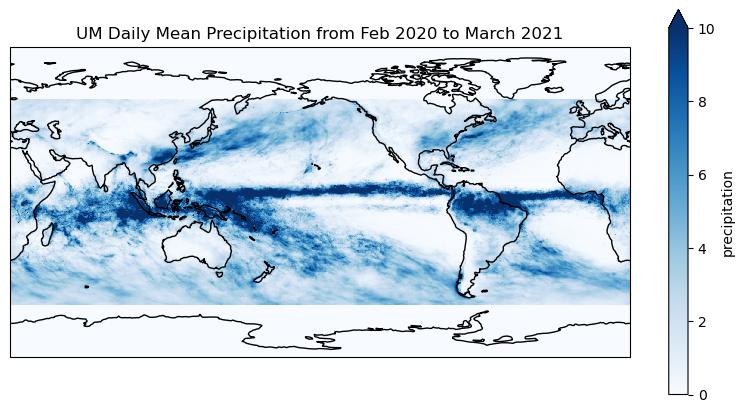

In [16]:
import cartopy.crs as ccrs

projection = ccrs.PlateCarree(central_longitude=205)
fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
season_imerg_merged[1] .plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM Daily Mean Precipitation from Feb 2020 to March 2021')